## Семинар 6: "Архитектуры и transfer learning"

ФИО:

In [59]:
import numpy as np
import pandas as pd
from skimage import io, transform
import os
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, utils
from torchvision import models

from torch.utils.data import Dataset, DataLoader



%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

In [2]:
models.AlexNet()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [23]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [50]:
class Normalize(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
    
        image = image.reshape((1, 96, 96))

        return {'image': torch.from_numpy(image.astype('float32')),
                'landmarks': torch.from_numpy(landmarks)}


transformed_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                    root_dir='dataset/train/',
                                    transform=transforms.Compose([
#                                                Normalize(),
                                               ToTensor()
                                           ]))
transformed_dataset_test = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                    root_dir='dataset/test/',
                                    transform=transforms.Compose([
#                                                Normalize(),
                                               ToTensor()
                                           ]))

dataloader_demo = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=1)
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=1)
dataloader_test = DataLoader(transformed_dataset_test, batch_size=4,
                        shuffle=True, num_workers=1)

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [49]:
t = torch.Tensor(1, 3, 96, 96)
fx = models.AlexNet().features
fx[0].stride=(2,2)
fx[0].padding = (12, 12)
fx.forward(Variable(t)).size()

torch.Size([1, 256, 6, 6])

In [64]:
from torch.autograd import Variable

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.AlexNet()
        self.model.features[0].stride = (2, 2)
        self.model.features[0].padding = (12, 12)
        for p in self.model.parameters():
            p.requires_grad = False
        n_ftrs = self.model.classifier[6].out_features
        self.model.classifier.add_module('7', nn.Linear(n_ftrs, 68*2))

    def forward(self, x):
        x = x.view(-1, 1, 96, 96) / 256.0
        x = x.expand(x.size(0), 3, 96, 96)
        x = self.model(x)
        x = x.view(-1, 68, 2)
        return x
    
model = Net()

In [65]:
optimizer = torch.optim.Adam(model.model.classifier[7].parameters(), lr=1e-2)

In [66]:
def train(epoch):
    model.train()
    for batch_idx, (data) in enumerate(dataloader):
        data, target = Variable(data['image']), Variable(data['landmarks'])
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.mse_loss(output, target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.data[0]))

for epoch in range(1, 5):
    train(epoch)
#     test()

Train Epoch: 1 [0/6221 (0%)]	Loss: 3265.652588
Train Epoch: 1 [640/6221 (10%)]	Loss: 3061.286133
Train Epoch: 1 [1280/6221 (21%)]	Loss: 2851.632812
Train Epoch: 1 [1920/6221 (31%)]	Loss: 2754.027344
Train Epoch: 1 [2560/6221 (41%)]	Loss: 2579.548584
Train Epoch: 1 [3200/6221 (51%)]	Loss: 2394.793457
Train Epoch: 1 [3840/6221 (62%)]	Loss: 2225.335938
Train Epoch: 1 [4480/6221 (72%)]	Loss: 2126.556396
Train Epoch: 1 [5120/6221 (82%)]	Loss: 2004.235962
Train Epoch: 1 [5760/6221 (92%)]	Loss: 1912.693481
Train Epoch: 2 [0/6221 (0%)]	Loss: 1779.706299
Train Epoch: 2 [640/6221 (10%)]	Loss: 1693.658325
Train Epoch: 2 [1280/6221 (21%)]	Loss: 1580.254028
Train Epoch: 2 [1920/6221 (31%)]	Loss: 1457.082886
Train Epoch: 2 [2560/6221 (41%)]	Loss: 1334.624146
Train Epoch: 2 [3200/6221 (51%)]	Loss: 1268.044922
Train Epoch: 2 [3840/6221 (62%)]	Loss: 1196.151245
Train Epoch: 2 [4480/6221 (72%)]	Loss: 1083.723511
Train Epoch: 2 [5120/6221 (82%)]	Loss: 1060.182007
Train Epoch: 2 [5760/6221 (92%)]	Loss: 97

In [60]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    print(landmarks_batch.shape)

    grid = utils.make_grid(images_batch)
    
#     plt.imshow(images_batch[0,0].numpy(), cmap='gray')
    plt.imshow(grid.numpy()[0], cmap='gray')

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * (im_size + 2),
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

def test():
    model.eval()
    for i_batch, sample_batched in enumerate(dataloader_demo):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['landmarks'].size())

        sample_batched['landmarks'] = model(Variable(sample_batched['image'])).data.view(-1,68,2)
        print(sample_batched['landmarks'].numpy().shape)
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


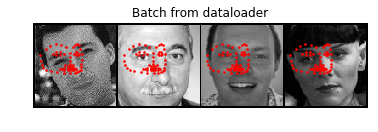

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


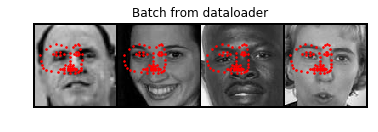

In [67]:
for _ in range(2):
    test()

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: